In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import datetime
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.plotting import scatter_matrix
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# 1. Importing Data

In [2]:
train=pd.read_csv('../input/spaceship-titanic/train.csv')
test=pd.read_csv('../input/spaceship-titanic/test.csv')

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 2. Data Description
> 2.1 Data Description
> PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
> 
> HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
> 
> CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
> Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
> Destination - The planet the passenger will be debarking to.
> Age - The age of the passenger.
> VIP - Whether the passenger has paid for special VIP service during the voyage.</font>
> RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
> Name - The first and last names of the passenger.

> **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 3. Check Missing Values

In [3]:
print(train.info())
print('_+_+_+_&*_*_*_*_*_')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
_+_+_+_&*_*_*_*_*_
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column

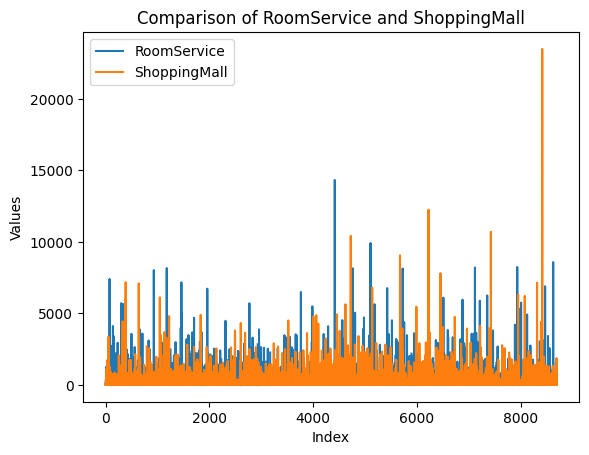

0

In [4]:
# scatter_matrix(train_test, alpha=0.2, figsize=(6, 6), diagonal='kde')
# plt.show()
plt.plot(train['RoomService'], label='RoomService')
plt.plot(train['ShoppingMall'], label='ShoppingMall')
plt.title('Comparison of RoomService and ShoppingMall')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()
sum(train['Transported'].isna())

# 3. Handling Missing Values¶

> Thanks to @Master Jiraiya

In [5]:
# First lets fill CryoSleep, based on totdal expenditure
exp_features=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train["Expenditure"]=train[exp_features].sum(axis="columns")
test["Expenditure"]=test[exp_features].sum(axis="columns")

# Zero expenditure indicate that they are in CryoSleep
train['CryoSleep']=np.where(train['Expenditure']==0,1,0)
test['CryoSleep']=np.where(test['Expenditure']==0,1,0)

# Also, if they are VIPs, they probably would not choose to be in CryoSleep
train['VIP']=np.where(train['CryoSleep']==0,1,0)
test['VIP']=np.where(test['CryoSleep']==0,1,0)

# Also, if Expenditure is 0, they probably are under 12
# minAge = int(train['Age'].mean())
# train['Age']=np.where(train['Expenditure']==0,0,minAge)
# test['Age']=np.where(test['Expenditure']==0,0,minAge)

train.drop(columns=["Expenditure"],inplace=True)
test.drop(columns=["Expenditure"],inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4277 non-null   int64  
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4277 non-null   int64  
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), int64(2), object(5)
memory usage: 434.5+ KB


In [6]:
#CryoSleep Train
train['CryoSleep'].replace({True: 1, False: 0}, inplace=True)

#Transported Train
train['Transported'] = train['Transported'].replace({True: 1, False: 0})

#HomePlanet Train
train['HomePlanet'].replace('Earth', 1, inplace=True)
train['HomePlanet'].replace('Europa', 2, inplace=True)
train['HomePlanet'].replace('Mars', 3, inplace=True)

#Destination Train
train['Destination'].replace('55 Cancri e', 1, inplace=True)
train['Destination'].replace('PSO J318.5-22', 2, inplace=True)
train['Destination'].replace('TRAPPIST-1e', 3, inplace=True)


#Vip Train
train['VIP'].replace({True: 1, False: 0}, inplace=True)


########################################################


#CryoSleep Test
test['CryoSleep'].replace({True: 1, False: 0}, inplace=True)

#Transported Test
# Don't have transported

#HomePlanet Test
test['HomePlanet'].replace('Earth', 1, inplace=True)
test['HomePlanet'].replace('Europa', 2, inplace=True)
test['HomePlanet'].replace('Mars', 3, inplace=True)

#Destination Test
test['Destination'].replace('55 Cancri e', 1, inplace=True)
test['Destination'].replace('PSO J318.5-22', 2, inplace=True)
test['Destination'].replace('TRAPPIST-1e', 3, inplace=True)

#Vip Test
test['VIP'].replace({True: 1, False: 0}, inplace=True)


train.head(3)
# test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,2.0,1,B/0/P,3.0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,1.0,0,F/0/S,3.0,24.0,1,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,2.0,0,A/0/S,3.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0


HomePlanet: {'Earth', 'Europa', 'Mars', nan}
{1,2,3,4}

Destination: {'55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan}
{1,2,3,4}

letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10}

Now we have 11 attribute to work with and they all are numeric


Now We can go to filling every null and nan cell in our dataframe

In [7]:
# Filled them with help of expenditure and VIP
# df["CryoSleep"].fillna(df["CryoSleep"].mode()[0],inplace=True)

# Filled them with help of expenditure and CryoSleep
# df["VIP"].fillna(df["VIP"].mode()[0],inplace=True)

#Data For Train
train["HomePlanet"].fillna(train["HomePlanet"].mode()[0],inplace=True)
train["Destination"].fillna(train["Destination"].mode()[0],inplace=True)
train["Cabin"].fillna(train["Cabin"].mode()[0],inplace=True)
train["Age"].fillna(int(train["Age"].mean()),inplace=True)
train["RoomService"].fillna(train["RoomService"].mean(),inplace=True)
train["FoodCourt"].fillna(train["FoodCourt"].mean(),inplace=True)
train["ShoppingMall"].fillna(train["ShoppingMall"].mean(),inplace=True)
train["Spa"].fillna(train["Spa"].mean(),inplace=True)
train["VRDeck"].fillna(train["VRDeck"].mean(),inplace=True)



#Data for Test
test["HomePlanet"].fillna(test["HomePlanet"].mode()[0],inplace=True)
test["Destination"].fillna(test["Destination"].mode()[0],inplace=True)
test["Cabin"].fillna(test["Cabin"].mode()[0],inplace=True)
test["Age"].fillna(int(test["Age"].mean()),inplace=True)
test["RoomService"].fillna(test["RoomService"].mean(),inplace=True)
test["FoodCourt"].fillna(test["FoodCourt"].mean(),inplace=True)
test["ShoppingMall"].fillna(test["ShoppingMall"].mean(),inplace=True)
test["Spa"].fillna(test["Spa"].mean(),inplace=True)
test["VRDeck"].fillna(test["VRDeck"].mean(),inplace=True)

# Define the bins and labels for AGE column
bins = [0, 15, 25, 35, 45, 60, 75, 90,120, 150]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Use pd.cut to scale the 'Age' column
train['Age'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)
test['Age'] = pd.cut(test['Age'], bins=bins, labels=labels, right=False)

#No Nan, Null or empty cell
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   8693 non-null   object  
 1   HomePlanet    8693 non-null   float64 
 2   CryoSleep     8693 non-null   int64   
 3   Cabin         8693 non-null   object  
 4   Destination   8693 non-null   float64 
 5   Age           8693 non-null   category
 6   VIP           8693 non-null   int64   
 7   RoomService   8693 non-null   float64 
 8   FoodCourt     8693 non-null   float64 
 9   ShoppingMall  8693 non-null   float64 
 10  Spa           8693 non-null   float64 
 11  VRDeck        8693 non-null   float64 
 12  Name          8493 non-null   object  
 13  Transported   8693 non-null   int64   
dtypes: category(1), float64(7), int64(3), object(3)
memory usage: 891.9+ KB


In [8]:
# Train Data
#Port or Starboard of the cabins
train['Port'] = train['Cabin'].str.split('/').str[-1]
train['Port'].replace('S', 0, inplace=True)
train['Port'].replace('P', 1, inplace=True)

#Class of the cabins
train['Place'] = train['Cabin'].str.split('/').str[0]
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
train['Place'] = train['Place'].map(letter_to_int)


#Number of cabins
train['Cabin'] = train['Cabin'].str.split('/').str[1]

#####################################
#####################################
#####################################

# Test Data

#Port or Starboard of the cabins
test['Port'] = test['Cabin'].str.split('/').str[-1]
test['Port'].replace('S', 0, inplace=True)
test['Port'].replace('P', 1, inplace=True)

#Class of the cabins
test['Place'] = test['Cabin'].str.split('/').str[0]
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
test['Place'] = test['Place'].map(letter_to_int)


#Number of cabins
test['Cabin'] = test['Cabin'].str.split('/').str[1]



train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Port,Place
0,0001_01,2.0,1,0,3.0,4,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,2
1,0002_01,1.0,0,0,3.0,2,1,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0,6
2,0003_01,2.0,0,0,3.0,5,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1


In [9]:
train[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']] = train[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']].astype('Int64')

test[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']] = test[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']].astype('Int64')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   Int64  
 2   CryoSleep     8693 non-null   Int64  
 3   Cabin         8693 non-null   Int64  
 4   Destination   8693 non-null   Int64  
 5   Age           8693 non-null   Int64  
 6   VIP           8693 non-null   Int64  
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
 14  Port          8693 non-null   Int64  
 15  Place         8693 non-null   Int64  
dtypes: Int64(8), float64(5), int64(1), object(2)
memory usage: 1.1+ MB


# Handling Expenditure data 

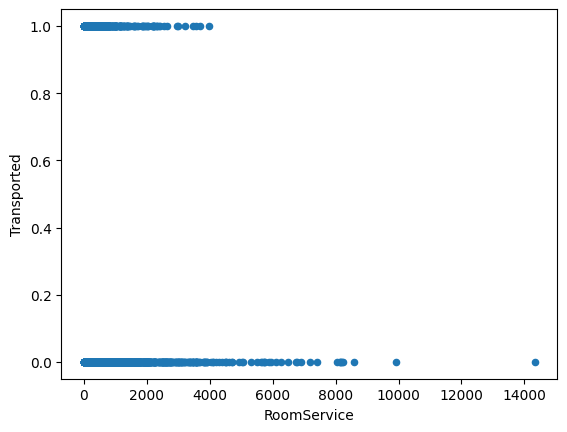

In [10]:
train.plot.scatter(x='RoomService', y='Transported')
plt.show()

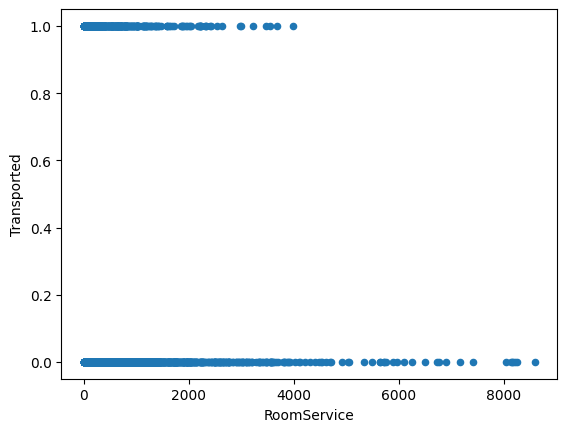

In [11]:
indexNames1 = train[ (train['RoomService'] > 9000)& (train['Transported'] == False)].index
indexNames2 = train[ (train['RoomService'] > 4000) & (train['Transported'] == True)].index

train.drop(indexNames1 , inplace=True)
train.drop(indexNames2 , inplace=True)

train.plot.scatter(x='RoomService', y='Transported')
plt.show()


# train.info()
# print(len(indexNames1))
# print(len(indexNames2))

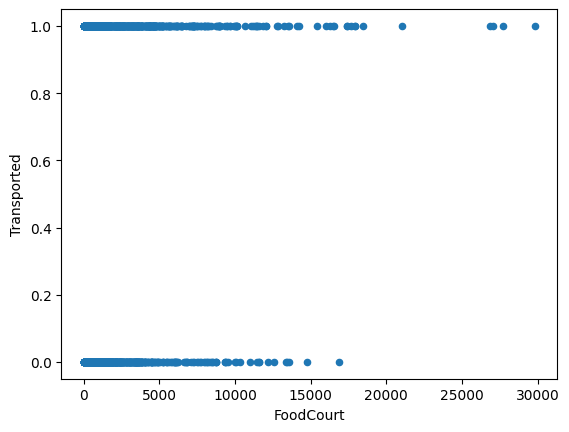

In [12]:
train.plot.scatter(x='FoodCourt', y='Transported')
plt.show()

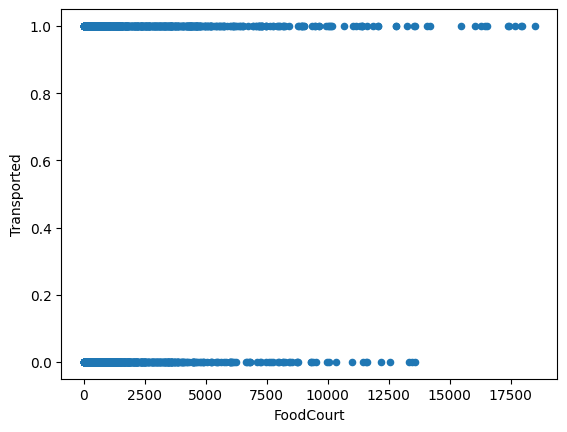

5
2


In [13]:
indexNames1 = train[ (train['FoodCourt'] > 20000) & (train['Transported'] == True)].index
indexNames2 = train[ (train['FoodCourt'] > 14000)& (train['Transported'] == False)].index

train.drop(indexNames1 , inplace=True)
train.drop(indexNames2 , inplace=True)

train.plot.scatter(x='FoodCourt', y='Transported')
plt.show()

print(len(indexNames1))
print(len(indexNames2))

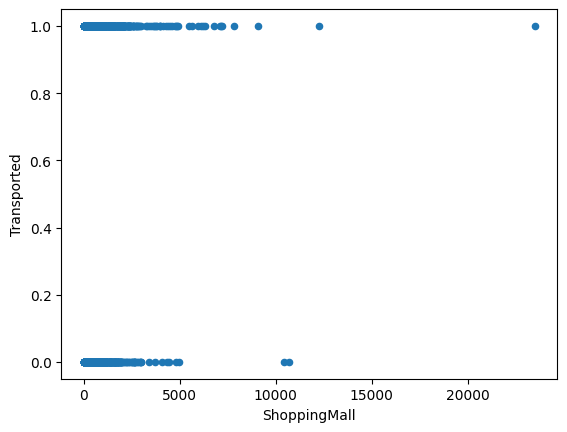

In [14]:
train.plot.scatter(x='ShoppingMall', y='Transported')
plt.show()

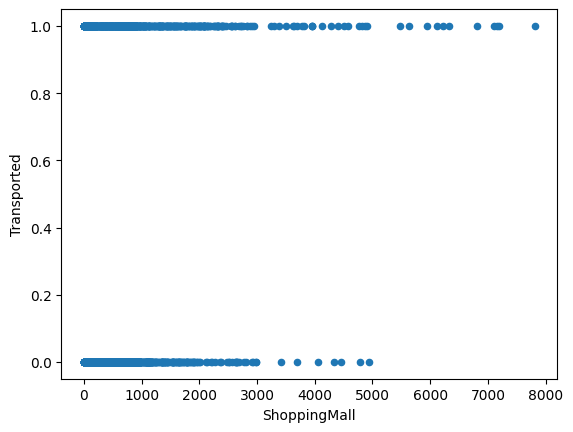

3
2


In [15]:
indexNames1 = train[ (train['ShoppingMall'] > 9000) & (train['Transported'] == True)].index
indexNames2 = train[ (train['ShoppingMall'] > 5000)& (train['Transported'] == False)].index

train.drop(indexNames1 , inplace=True)
train.drop(indexNames2 , inplace=True)

train.plot.scatter(x='ShoppingMall', y='Transported')
plt.show()

print(len(indexNames1))
print(len(indexNames2))

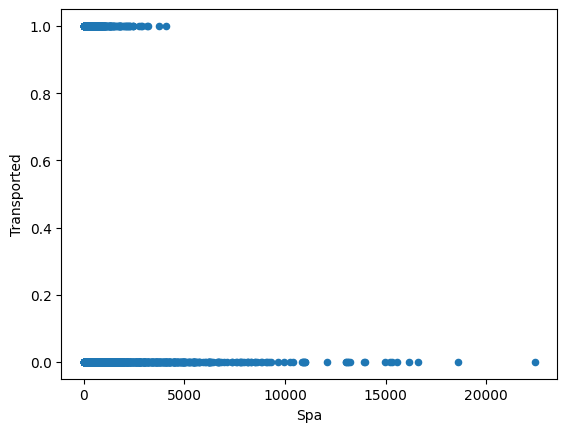

In [16]:
train.plot.scatter(x='Spa', y='Transported')
plt.show()

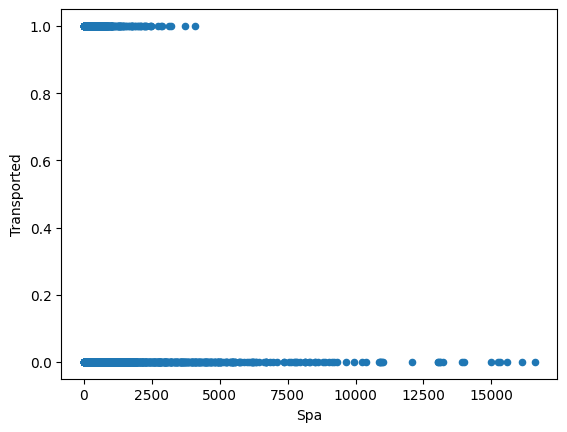

0
2


In [17]:
indexNames1 = train[ (train['Spa'] > 4500) & (train['Transported'] == True)].index
indexNames2 = train[ (train['Spa'] > 17500)& (train['Transported'] == False)].index

train.drop(indexNames1 , inplace=True)
train.drop(indexNames2 , inplace=True)

train.plot.scatter(x='Spa', y='Transported')
plt.show()

print(len(indexNames1))
print(len(indexNames2))

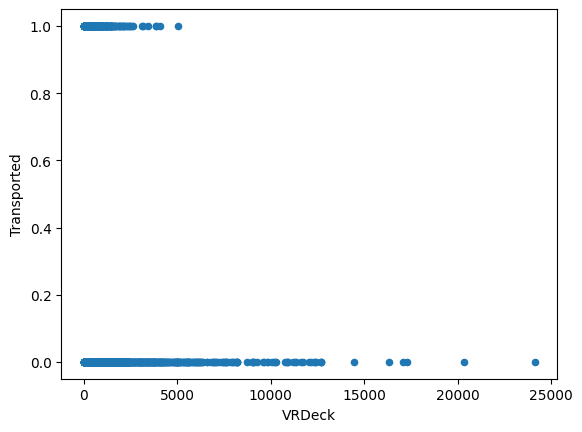

In [18]:
train.plot.scatter(x='VRDeck', y='Transported')
plt.show()

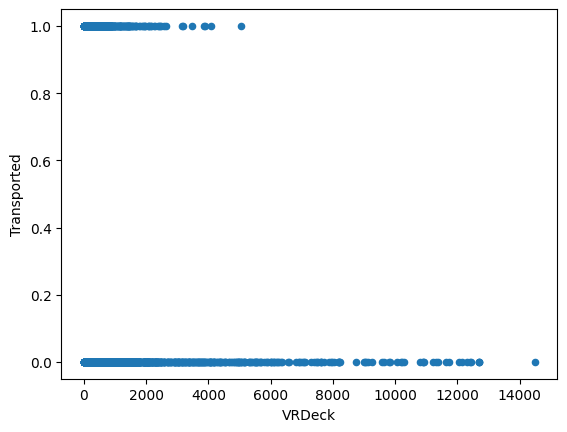

0
5


In [19]:
indexNames1 = train[ (train['VRDeck'] > 5100) & (train['Transported'] == True)].index
indexNames2 = train[ (train['VRDeck'] > 15000)& (train['Transported'] == False)].index

train.drop(indexNames1 , inplace=True)
train.drop(indexNames2 , inplace=True)

train.plot.scatter(x='VRDeck', y='Transported')
plt.show()

print(len(indexNames1))
print(len(indexNames2))

In [20]:
##Apply square root transformation

## Train Data
train['RoomService'] = train['RoomService']**0.5
train['FoodCourt'] = train['FoodCourt']**0.5
train['ShoppingMall'] = train['ShoppingMall']**0.5
train['Spa'] = train['Spa']**0.5
train['VRDeck'] = train['VRDeck']**0.5


## Test Data
test['RoomService'] = test['RoomService']**0.5
test['FoodCourt'] = test['FoodCourt']**0.5
test['ShoppingMall'] = test['ShoppingMall']**0.5
test['Spa'] = test['Spa']**0.5
test['VRDeck'] = test['VRDeck']**0.5

train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Port,Place
0,0001_01,2,1,0,3,4,0,0.000000,0.000000,0.0,0.000000,0.00000,Maham Ofracculy,0,1,2
1,0002_01,1,0,0,3,2,1,10.440307,3.000000,5.0,23.430749,6.63325,Juanna Vines,1,0,6
2,0003_01,2,0,0,3,5,1,6.557439,59.799666,0.0,81.945104,7.00000,Altark Susent,0,0,1


In [21]:
# ## Apply log transformation

# ## Train Data
# train['RoomService'] = np.log1p(train['RoomService'])
# train['FoodCourt'] = np.log1p(train['FoodCourt'])
# train['ShoppingMall'] = np.log1p(train['ShoppingMall'])
# train['Spa'] = np.log1p(train['Spa'])
# train['VRDeck'] = np.log1p(train['VRDeck'])


# ## Test Data
# test['RoomService'] = np.log1p(test['RoomService'])
# test['FoodCourt'] = np.log1p(test['FoodCourt'])
# test['ShoppingMall'] = np.log1p(test['ShoppingMall'])
# test['Spa'] = np.log1p(test['Spa'])
# test['VRDeck'] = np.log1p(test['VRDeck'])
# train.head(3)

Train Data


<Axes: >

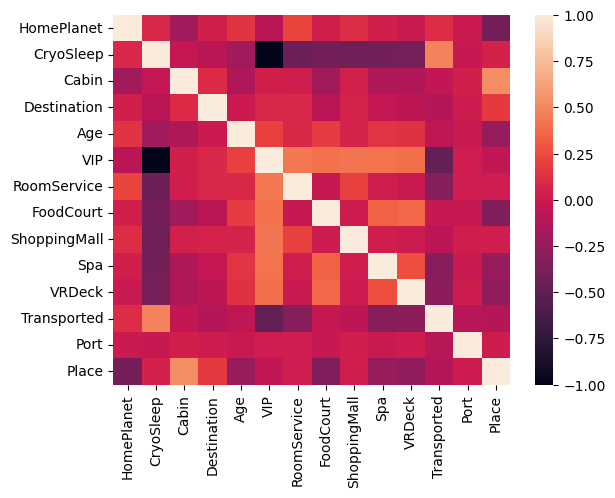

In [22]:
train_num = train.select_dtypes(include=['float64', 'int64'])

# Calculate the correlations of numerical columns
corr = train_num.corr()

print("Train Data")
sns.heatmap(corr, annot=False)

Test Data


<Axes: >

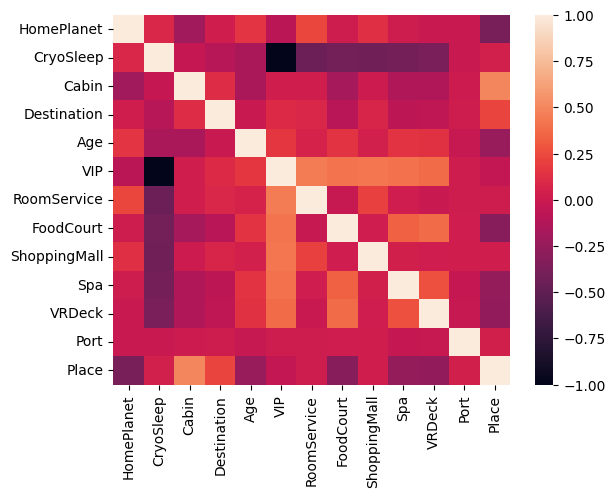

In [23]:
test_num = test.select_dtypes(include=['float64', 'int64'])

# Calculate the correlations of numerical columns
corr = test_num.corr()

print("Test Data")
sns.heatmap(corr, annot=False)

In [24]:
#print('cryo Taransported: ', sum(df[df.CryoSleep == 1].Transported), 'transported: ',sum(df.Transported))
# # Calculate mean
# df['Mean_luxury'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)

# df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# df['BigSpender'] = np.where(df.Mean_luxury > 1000, 1,0)
# df['Mid_Spender'] = np.where(df.Mean_luxury >= 500, 1,0)
# df['Non_Spender'] = np.where(df.Mean_luxury == 0, 1,0)
# df.head(3)

{1:'55 Cancri e', 2:'PSO J318.5-22', 3:'TRAPPIST-1e'}
{1:'Earth', 2:'Europa', 3:'Mars'}
<<<<<HomePlanet to Destination>>>>
1 to 1 >>> 721
1 to 2 >>> 728
1 to 3 >>> 3354
--------------    
2 to 1 >>> 193
2 to 2 >>> 49
2 to 3 >>> 1517
-------------- 
3 to 1 >>> 886
3 to 2 >>> 19
3 to 3 >>> 1226
-------------- 

In [25]:
### Train Data
newTrain = train
train_ids = newTrain['PassengerId'].copy()
train_trs = newTrain['Transported'].copy()
newTrain.drop(columns=['PassengerId','Name','Transported'],inplace=True)


#####################


### Test Data
newTest = test
test_ids = newTest['PassengerId'].copy()
newTest.drop(columns=['PassengerId','Name'],inplace=True)


newTrain.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Port,Place
0,2,1,0,3,4,0,0.000000,0.000000,0.0,0.000000,0.00000,1,2
1,1,0,0,3,2,1,10.440307,3.000000,5.0,23.430749,6.63325,0,6
2,2,0,0,3,5,1,6.557439,59.799666,0.0,81.945104,7.00000,0,1


In [26]:
newTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8672 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8672 non-null   Int64  
 1   CryoSleep     8672 non-null   Int64  
 2   Cabin         8672 non-null   Int64  
 3   Destination   8672 non-null   Int64  
 4   Age           8672 non-null   Int64  
 5   VIP           8672 non-null   Int64  
 6   RoomService   8672 non-null   float64
 7   FoodCourt     8672 non-null   float64
 8   ShoppingMall  8672 non-null   float64
 9   Spa           8672 non-null   float64
 10  VRDeck        8672 non-null   float64
 11  Port          8672 non-null   Int64  
 12  Place         8672 non-null   Int64  
dtypes: Int64(8), float64(5)
memory usage: 1016.2 KB


In [27]:
newTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   Int64  
 1   CryoSleep     4277 non-null   Int64  
 2   Cabin         4277 non-null   Int64  
 3   Destination   4277 non-null   Int64  
 4   Age           4277 non-null   Int64  
 5   VIP           4277 non-null   Int64  
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
 11  Port          4277 non-null   Int64  
 12  Place         4277 non-null   Int64  
dtypes: Int64(8), float64(5)
memory usage: 467.9 KB


In [28]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(newtrainDF.drop('Transported',axis=1), 
#                                                   df['Transported'], test_size=0.30, 
#                                                     random_state=101)
# newtrainDF.head(1)

In [29]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(newTrain, train_trs)

LogisticRegression(max_iter=10000)

In [30]:
# df_test['stSpenders'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].std(axis=1)
# df_test = df_test.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
# df_test.head()

In [31]:
 predictions = logmodel.predict(newTest)

In [32]:
df_predictions = pd.DataFrame()
df_predictions['PassengerId'] = pd.Series(test_ids.T.values)
df_predictions['Transported'] = pd.Series(predictions)
df_predictions.Transported = np.where(df_predictions.Transported==1,True,False)
df_predictions.to_csv("24rdAttempt.csv", sep=',', index=False)
df_predictions.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In this report, the 'Precision' column tells us the proportion of positive identifications (i.e., the passenger was transported) that were actually correct. The 'Recall' column tells us the proportion of actual positives that were identified correctly. The 'F1-score' is a function of Precision and Recall and gives a balanced measure of the model's performance.

Remember, this is a basic model. Depending on the performance of the model, you might need to consider more advanced techniques such as handling class imbalance, feature engineering, or using a more complex model.